In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer

/home/nirjhar/Python Codes/Machine Learning/torchenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = torchvision.datasets.MNIST(root="Data", download=True, train=True, transform=None, target_transform=None)
test_data = torchvision.datasets.MNIST(root="Data", download=True, train=False, transform=None, target_transform=None)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:20<00:00, 495kB/s] 


Extracting Data/MNIST/raw/train-images-idx3-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 52.7kB/s]


Extracting Data/MNIST/raw/train-labels-idx1-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:08<00:00, 191kB/s] 


Extracting Data/MNIST/raw/t10k-images-idx3-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.01MB/s]

Extracting Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data/MNIST/raw



In [3]:
X_train = []

for i in range(60000):
    X_train.append([np.array(next(iter(train_data[i])))])
X_train = np.array(X_train)

In [4]:
Y_train = []
for i in range(60000):
    Y_train.append((train_data[i])[1])
    
Y_train = np.array(Y_train)

In [5]:
X_test = []

for i in range(10000):
    X_test.append([np.array(next(iter(test_data[i])))])
X_test = np.array(X_test)

In [6]:
Y_test = []

for i in range(10000):
    Y_test.append((test_data[i])[1])
Y_test = np.array(Y_test)

In [7]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))

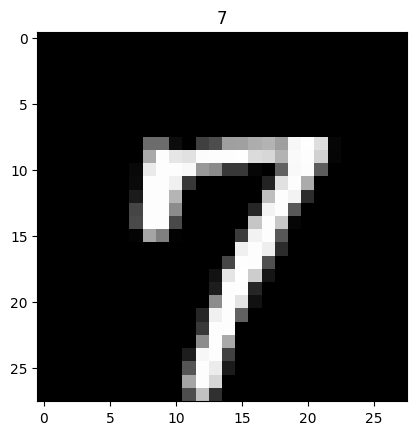

In [8]:
i = np.random.randint(60000)

plt.imshow(X_train[i].squeeze(), cmap="grey")
plt.title(Y_train[i])
plt.show()

## Model From scratch

In [9]:
X_flat_train = []
for i in range(60000):
    X_flat_train.append(X_train[i].squeeze().flatten())
    
X_flat_train = np.array(X_flat_train).T/255

X_flat_test = []
for i in range(10000):
    X_flat_test.append(X_test[i].squeeze().flatten())
    
X_flat_test = np.array(X_flat_test).T/255

In [10]:
X_flat_train.shape, X_flat_test.shape

((784, 60000), (784, 10000))

In [11]:
Y_train.shape, Y_test.shape

((60000,), (10000,))

In [12]:
def ReLU(X):
    return np.maximum(0,X)

def softmax(X):
    return (np.exp(X)/sum(np.exp(X)))

def derivative_ReLU(X):
    return X>0

In [13]:
def parameters():
    np.random.seed(42)
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2

In [14]:
def encodeY(Y):
    oneY = np.zeros((Y.size, 10))
    oneY[np.arange(Y.size), Y] = 1
    
    return oneY.T

In [15]:
def forward(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

def backward(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    encodedY = encodeY(Y)
    dZ2 = A2 - encodedY
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * derivative_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 = W1 - lr*dW1
    W2 = W2 - lr*dW2
    b1 = b1 - lr*db1
    b2 = b2 - lr*db2
    
    return W1, b1, W2, b2

In [16]:

def accuracy(predictions, Y):
    # print(predictions, Y)
    return np.sum(predictions == Y)/Y.size

In [17]:
def gradient_descent(X_train, Y_train, X_test, Y_test, EPOCHS, lr):
    W1, b1, W2, b2 = parameters()
    timeron = timer()
    for epoch in tqdm(range(EPOCHS)):
        
        # Train
        
        Z1, A1, Z2, A2 = forward(W1=W1, b1=b1, W2=W2, b2=b2, X=X_train)
        dW1, db1, dW2, db2 = backward(Z1, A1, Z2, A2, W1, W2, X_train, Y_train)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
        A2_train = A2
        # Test
            
        Z1, A1, Z2, A2 = forward(W1=W1, b1=b1, W2=W2, b2=b2, X=X_test)
        dW1, db1, dW2, db2 = backward(Z1, A1, Z2, A2, W1, W2, X_test, Y_test)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
        A2_test = A2
        
        if (epoch % 50 == 0):
            print(f"Epoch Number : {epoch}")
            print(f"Train Accuracy : {(accuracy(np.argmax(A2_train,0), Y_train)*100):.2f}% | Test Accuracy : {(accuracy(np.argmax(A2_test,0), Y_test)*100):.2f}%")
    
    timeroff = timer()
    print(f"Time Taken On CPU : {timeroff-timeron:.2f} seconds")
    # return W1, b1, W2, b2    
            

In [18]:
gradient_descent(X_train=X_flat_train, Y_train=Y_train, X_test=X_flat_test, Y_test=Y_test, EPOCHS=500, lr=0.1)

  0%|          | 1/500 [00:00<02:32,  3.27it/s]

Epoch Number : 0
Train Accuracy : 15.75% | Test Accuracy : 15.61%


 10%|█         | 51/500 [00:12<02:23,  3.13it/s]

Epoch Number : 50
Train Accuracy : 57.38% | Test Accuracy : 59.46%


 20%|██        | 102/500 [00:24<01:16,  5.18it/s]

Epoch Number : 100
Train Accuracy : 71.58% | Test Accuracy : 72.65%


 30%|███       | 152/500 [00:35<01:12,  4.81it/s]

Epoch Number : 150
Train Accuracy : 77.10% | Test Accuracy : 78.29%


 40%|████      | 202/500 [00:46<01:03,  4.66it/s]

Epoch Number : 200
Train Accuracy : 80.36% | Test Accuracy : 81.68%


 50%|█████     | 252/500 [00:57<00:49,  5.04it/s]

Epoch Number : 250
Train Accuracy : 82.63% | Test Accuracy : 84.09%


 60%|██████    | 302/500 [01:07<00:30,  6.47it/s]

Epoch Number : 300
Train Accuracy : 84.25% | Test Accuracy : 85.72%


 70%|███████   | 352/500 [01:15<00:21,  7.01it/s]

Epoch Number : 350
Train Accuracy : 85.34% | Test Accuracy : 86.74%


 80%|████████  | 402/500 [01:22<00:14,  6.92it/s]

Epoch Number : 400
Train Accuracy : 86.15% | Test Accuracy : 87.59%


 90%|█████████ | 451/500 [01:34<00:10,  4.70it/s]

Epoch Number : 450
Train Accuracy : 86.77% | Test Accuracy : 88.19%


100%|██████████| 500/500 [01:47<00:00,  4.65it/s]

Time Taken On CPU : 107.47 seconds
